In [14]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pickle
%matplotlib inline

In [19]:
img = plt.imread('D:/ML/Ros_Curve_Lane_Detection/test_image.jpg')

In [20]:
data = pickle.load( open( "camera_calibration.p", "rb" ) )
mtx = data['mtx']
dist = data['dist']

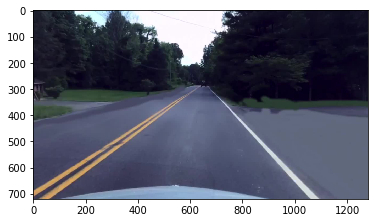

In [21]:
dst = cv2.undistort(img, mtx, dist, None, mtx)
plt.imshow(dst)

In [46]:
# Thresholding by sobel
# First Gradient absolute value
# Second Gradient magnitude.
# Third Gradient absolute value

def gradient_abs_value_mask(image, orient='x',sobel_kernel=3, thresh_min=20, thresh_max=100):
    """
    Masks the image based on gradient absolute value.
    Parameters
    ----------
    image           : Image to mask.
    sobel_kernel    : Kernel of the Sobel gradient operation.
    axis            : Axis of the gradient, 'x' or 'y'.
    threshold       : Value threshold for it to make it to appear in the mask.
    Returns
    -------
    Image mask with 1s in activations and 0 in other pixels.
    """
    
    gray_img = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)

    # We will use sobel y
    
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray_img, cv2.CV_64F, 1, 0,ksize=sobel_kernel))
    elif orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray_img, cv2.CV_64F, 0, 1,ksize=sobel_kernel))
    
    # Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    
    # Create a copy and apply the threshold
    # Create a mask of 1's where the scaled gradient magnitude is > thresh_min and < thresh_max
    binary_output = np.zeros_like(scaled_sobel)
    
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    return binary_output

In [44]:
def gradient_magnitude_mask(image, sobel_kernel=3, threshold=(30, 100)):
    """
    Masks the image based on gradient magnitude.
    Parameters
    ----------
    image           : Image to mask.
    sobel_kernel    : Kernel of the Sobel gradient operation.
    threshold       : Magnitude threshold for it to make it to appear in the mask.
    Returns
    -------
    Image mask with 1s in activations and 0 in other pixels.
    """
    # Take the gradient in x and y separately
    sobel_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobel_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the magnitude
    magnitude = np.sqrt(sobel_x ** 2 + sobel_y ** 2)
    # Scale to 8-bit (0 - 255) and convert to type = np.uint8
    magnitude = (magnitude * 255 / np.max(magnitude)).astype(np.uint8)
    # Create a binary mask where mag thresholds are met
    binary_output = np.zeros_like(magnitude)
    binary_output[(magnitude >= threshold[0]) & (magnitude <= threshold[1])] = 1
    # Return this mask as your binary_output image
    return binary_output

In [47]:
def gradient_direction_mask(image, sobel_kernel=3, threshold=(0, np.pi / 2)):
    """
    Masks the image based on gradient direction.
    Parameters
    ----------
    image           : Image to mask.
    sobel_kernel    : Kernel of the Sobel gradient operation.
    threshold       : Direction threshold for it to make it to appear in the mask.
    Returns
    -------
    Image mask with 1s in activations and 0 in other pixels.
    """
    # Take the gradient in x and y separately
    sobel_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobel_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the x and y gradients and calculate the direction of the gradient
    direction = np.arctan2(np.absolute(sobel_y), np.absolute(sobel_x))
    # Create a binary mask where direction thresholds are met
    binary_output = np.zeros_like(direction)
    # Return this mask as your binary_output image
    binary_output[(direction >= threshold[0]) & (direction <= threshold[1])] = 1
    return binary_output

In [77]:
def hls_thresh(img, thresh=(100, 255)):
    """
    Convert RGB to HLS and threshold to binary image using S channel
    """
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    return binary_output

In [82]:
def combined_thresh(img):
    abs_bin = gradient_abs_value_mask(img, orient='x', thresh_min=50, thresh_max=255)
    mag_bin = gradient_magnitude_mask(img, sobel_kernel=3, threshold=(50, 255))
    dir_bin = gradient_direction_mask(img, sobel_kernel=15, threshold=(0.7, 1.3))
    hls_bin = hls_thresh(img, thresh=(170, 255))

    combined = np.zeros_like(dir_bin)
    combined[(abs_bin == 1 | ((mag_bin == 1) & (dir_bin == 1)))| hls_bin ] = 1

    return combined  # DEBUG

In [83]:
img = combined_thresh(dst) 

ValueError: operands could not be broadcast together with shapes (720,1280,3) (720,1280) 

In [ ]:
plt.imshow(img)